In [8]:
def query_generator(county_fips, time):
    query = ("""
PREFIX covid: <http://covid.geog.ucsb.edu/lod/ontology/>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX covid-obs-property: <http://covid.geog.ucsb.edu/lod/observedproperty/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX census: <http://econ.geog.ucsb.edu/lod/census/>
PREFIX census-obs-property: <http://covid.geog.ucsb.edu/lod/census_obs_property/>
PREFIX time: <http://www.w3.org/2006/time#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?placeName ?modelName (xsd:float(?census_pop_val)/xsd:float(?census_area_val) AS ?census_density) (min(abs(?predict_value-?groundtruth_value)) as ?min_gap)  where {
	
    ?target a covid:Target ;
            sosa:observedProperty covid-obs-property:cum_death ;
            sosa:phenomenonTime ?time ;
            covid:point ?predict_value ;
            sosa:hasFeatureOfInterest ?place ;
            ^sosa:hasMember/^sosa:hasMember/sosa:madeBySensor ?model ;
     .
    
    ?model rdfs:label ?modelName .

    ?groundtruth a covid:GroundTruth ;
            sosa:phenomenonTime ?time ;
            sosa:observedProperty covid-obs-property:cum_death ;
            sosa:hasFeatureOfInterest ?place ;
            covid:point ?groundtruth_value .
  
    ?census_stat_col a census:StatsCollection ;
            sosa:hasFeatureOfInterest ?place ;
            sosa:hasMember ?census_pop ,
            ?census_area .
    
    ?census_pop covid:point ?census_pop_val;
                sosa:observedProperty census-obs-property:POPESTIMATE2019 . 
    ?census_area covid:point ?census_area_val;
                sosa:observedProperty census-obs-property:TotalArea . 
        
    ?place covid:placeFIPS '%s' ;
           covid:hasPlaceName ?placeName.
    
   	?time time:inXSDDateTime '%s' .

 }
group by ?placeName ?modelName ?census_pop_val ?census_area_val
order by ?min_gap
""")% (county_fips, time)
    return query


### This function organizes the queries results from query_generator(model_url, date_str)

def extract_results(result):
    result_list = []
    
    for item in result['results']['bindings']:
        result_list.append([item['placeName']['value'], item['modelName']['value'], item['min_gap']['value'], item['census_density']['value']])
    
    return result_list

In [ ]:
import pandas as pd
from pymantic import sparql
import csv
import plotly.express as px
import csv

state_fips = pd.read_csv("./fips-codes/state_fips_master.csv")
state_fips['fips'] = state_fips['fips'].apply(lambda x: str(x).zfill(2))


fips_state_list = state_fips['fips'].tolist()
result_out = pd.DataFrame(columns=['Place Name', 'Model', 'Error', 'Population Density']) 

for item in fips_state_list:
    print("processing county:%s"%item)    
    #query_item = query_generator(item, "2021-01-09")
    query_item = query_generator(item, "2021-01-16")
    server = sparql.SPARQLServer('http://128.111.106.227:7201/repositories/Covid-KG')
    result = server.query(query_item)
    result_list = extract_results(result)
    result_pd = pd.DataFrame(result_list, columns =['Place Name', 'Model', 'Error', 'Population Density'])  
    
    result_out = result_out.append(result_pd)

processing county:01
processing county:02
processing county:04
processing county:05
processing county:06
processing county:08
processing county:09
processing county:10
processing county:12
processing county:13
processing county:15
processing county:16
processing county:17
processing county:18
processing county:19
processing county:20
processing county:21
processing county:22
processing county:23
processing county:24
processing county:25
processing county:26
processing county:27
processing county:28
processing county:29


In [34]:
import pickle
with open("accuracyDeviation_popDensity_20210109.p", 'wb') as f:
    pickle.dump(result_out, f)

In [15]:
len(list(set(result_out['Model'])))

51

In [20]:
result_out.dtypes

Place Name            object
Model                 object
Error                 object
Population Density    object
dtype: object

In [37]:
def deviationAccuracy_popDensity(model_name):
    deviation_pop = result_out[result_out['Model'] == model_name]
    if len(deviation_pop) == 50:
        deviation_pop['Error'] =  pd.to_numeric(deviation_pop['Error'])
        deviation_pop['Population Density'] = pd.to_numeric(deviation_pop['Population Density'])
    
        accuracy_density_corr = deviation_pop['Error'].corr(deviation_pop['Population Density'])
        return accuracy_density_corr
    else:
        print("no enough data to compute the correlation")

In [38]:
model_deviation_density_corr = {}
for model_name in list(set(result_out['Model'])):
    
    model_deviation_density_corr[model_name] = deviationAccuracy_popDensity(model_name)

no enough data to compute the correlation
no enough data to compute the correlation
no enough data to compute the correlation
no enough data to compute the correlation
no enough data to compute the correlation
no enough data to compute the correlation
no enough data to compute the correlation
no enough data to compute the correlation


/home/rui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/rui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [60]:
model_deviation_density_corr_pd = pd.DataFrame(list(model_deviation_density_corr.items()),columns = ['Model','Correlation']) 
model_deviation_density_corr_pd = model_deviation_density_corr_pd.dropna()

In [61]:
import matplotlib.pyplot as plt

model_deviation_density_corr_pd['colors'] = ['red' if x < 0 else 'green' for x in model_deviation_density_corr_pd['Correlation']]
model_deviation_density_corr_pd.sort_values('Correlation', inplace=True)
model_deviation_density_corr_pd.reset_index(inplace=True)

In [79]:
model_deviation_density_corr_pd

,index,Model,Correlation,colors
0,41,Karlen-pypm,-0.081212,red
1,3,epiforecasts-ensemble1,-0.040028,red
2,16,DDS-NBDS,-0.015218,red
3,46,CovidAnalytics-DELPHI,-0.002898,red
4,17,MIT_CritData-GBCF,0.003123,green
5,37,Covid19Sim-Simulator,0.012496,green
6,27,COVIDhub-ensemble,0.015474,green
7,28,SteveMcConnell-CovidComplete,0.020169,green
8,19,Microsoft-DeepSTIA,0.035696,green
9,50,JHU_IDD-CovidSP,0.038081,green


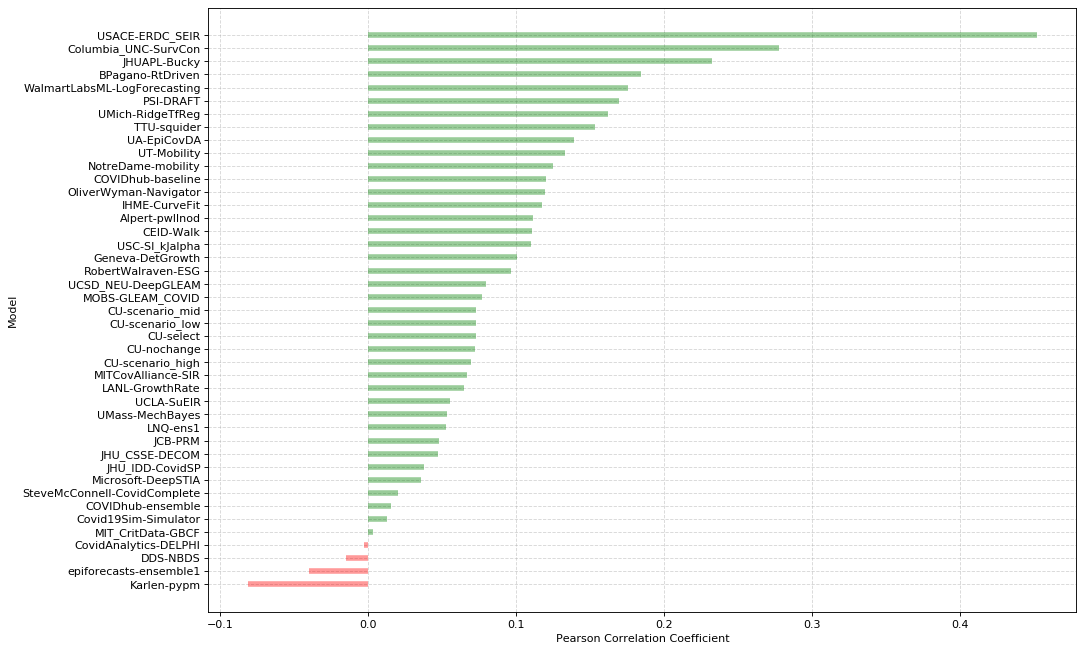

In [75]:
# Draw plot
plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y=model_deviation_density_corr_pd.index, xmin=0, xmax=model_deviation_density_corr_pd.Correlation, color=model_deviation_density_corr_pd.colors, alpha=0.4, linewidth=5)

# Decorations
plt.gca().set(ylabel='Model', xlabel='Pearson Correlation Coefficient')
plt.yticks(model_deviation_density_corr_pd.index, model_deviation_density_corr_pd.Model, fontsize=10)
#plt.title('Correlation of Model Accuracy and Population Density', fontdict={'size':15})
plt.grid(linestyle='--', alpha=0.5)
plt.savefig('accuracy_pop_corr.png', bbox_inches = "tight")
plt.show()